# MIR Final Project: Chuk, Mao

This Colab Notebook hosts the final project for the Fall 2022 MIR (MPATE-GE 2623) course, instructed by Magdalena Fuentes.

## 0. Introduction

### 0.1 Task

This final project is aimed at evaluating a piano transription model with a multi-f0, MIDI-to-MIDI comparison metric with `mir_eval.multipitch`.


42 audio test clips from the classical repertoire are performed by 2 players on a Yamaha Disklavier, which also outputs ground truth (reference) MIDI files that is perfectly aligned with the actual performance.


MIDI estimation is generated with Piano-Scribe, a web application implementation of the following paper:

<blockquote>
Hawthorne, C., Elsen, E., Song, J., Roberts, A., Simon, I., Raffel, C., ... & Eck, D. (2017). Onsets and frames: Dual-objective piano transcription. arXiv preprint arXiv:1710.11153.
</blockquote>

Piano-Scribe link: https://piano-scribe.glitch.me


### 0.2 Divided Workload
Alex Chuk:
1. Recording Session: setup and performance
2. Dataset: Data structuring and archiving
3. Coding: coded MIDI data import, storage as Python dictionaries, data analysis and visualization

Jiawen Mao:
1. Recording session: setup and performance
2. Dataset: audio post-production and MIDI export, data augmentation with pink noise
3. Coding: finalized coding pipeline; coded MIDI file parsing and multipitch evaluation functions

### 0.3 Dataset Overview
See Google Doc: '/content/drive/MyDrive/MIRFP/Data documentation'

## 1. Set up Colab environment

In [1]:
# Mount Colab onto Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install dependencies

!pip install pretty_midi
!pip install mir_eval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 7.3 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=868e534626c947a73ae5ccf0d96a889882abebe5c14e77596e0522beafc18397
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100703 sha256=c2bd752167d733c63f6d8ffd7358493be935161c6ab3846f91238f4dae382d50
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
Successfully built mir_eval


In [3]:
# Import Python packages

import numpy as np
import librosa
import librosa.display
import mir_eval
import mir_eval.display
import pretty_midi
from re import search

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
import os

### 1.1 Specify directory and file path

To run, put the whole project folder, MIRFP, under '/content/drive/MyDrive'.


In [4]:
# Specify folder root path, the ones without the file names

data_home = '/content/drive/MyDrive/ColabNotebooks/MIRFP/' # maybe an extra project_home?
!ls '/content/drive/MyDrive/ColabNotebooks/MIRFP/' # check files

ref_midi_home = 'MIDI_refMIDI/'
est_midi_home = 'MIDI_estMIDI/'


 Audio			   'MIR Final Project Code-Chuk, Mao.ipynb'
'Data documentation.docx'  'Presentation - Chuk, Mao.pptx'
 load.txt		    Scores
 MIDI_estMIDI		    temp.txt
 MIDI_refMIDI


## 2. Define Functions and Metrics

### 2.1 Extract MIDI data with PrettyMIDI

In [5]:
# Let's look at what's in this MIDI file
def midi_overview(midi_name):

    '''
    For a given MIDI file name, display its file path, note numbers, and duration in seconds.
    By default, our MIDI files are mono-instrument; to call this instrument object, use pm.instruments[0].

    Parameters
    ----------
    midi_name:  str
      Name of MIDI file, e.g. 'Bach_Alex_MIDI.mid'

    Returns
    -------
    None

    '''

    if search('estMIDI', midi_name):
        midi_path = data_home + est_midi_home + midi_name
    else:
        midi_path = data_home + ref_midi_home + midi_name

    pm = pretty_midi.PrettyMIDI(midi_path)

    print('The file path for {} is {}'.format(midi_name, midi_path))
    print('The duration of this file is {:.3f} seconds'.format(pm.get_end_time()))
    print('This file has {} notes'.format(len(pm.instruments[0].notes)))


    return

In [6]:
def plot_piano_roll(midi_name, start_pitch, end_pitch, fs=100):

    '''
    Use librosa's specshow function for displaying piano roll.

    Parameters
    ----------
    midi_name:  str
      Name of MIDI file, e.g. 'Bach_Alex_MIDI.mid'

    start_pitch, end_pitch: int
      MIDI note numbers of upper and lower display range

    fs: int
      Sampling frequency of piano roll columns

    Returns
    -------
    None
    '''

    if search('estMIDI', midi_name):
        midi_path = data_home + est_midi_home + midi_name
    else:
        midi_path = data_home + ref_midi_home + midi_name

    pm = pretty_midi.PrettyMIDI(midi_path)

    # Pedals will be reflected as elongation of notes in the piano roll.
    # If None, then CC64 message is ignored. Default is 64.
    librosa.display.specshow(pm.get_piano_roll(fs, pedal_threshold=64)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                           fmin=pretty_midi.note_number_to_hz(start_pitch))




    return


The file path for Debussy2_Alex_MIDI.mid is /content/drive/MyDrive/ColabNotebooks/MIRFP/MIDI_refMIDI/Debussy2_Alex_MIDI.mid
The duration of this file is 19.421 seconds
This file has 170 notes


<ipython-input-6-79743d5a1606>:31: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs, pedal_threshold=64)[start_pitch:end_pitch],


The file path for Debussy2_Alex_U87_estMIDI.mid is /content/drive/MyDrive/ColabNotebooks/MIRFP/MIDI_estMIDI/Debussy2_Alex_U87_estMIDI.mid
The duration of this file is 19.518 seconds
This file has 121 notes


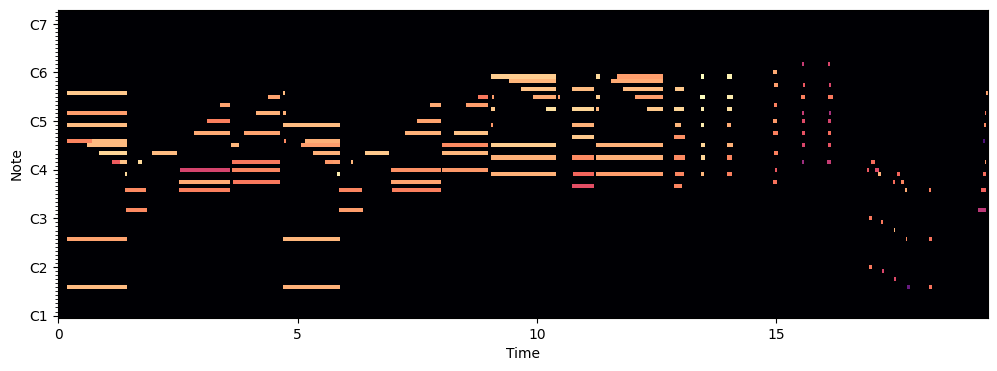

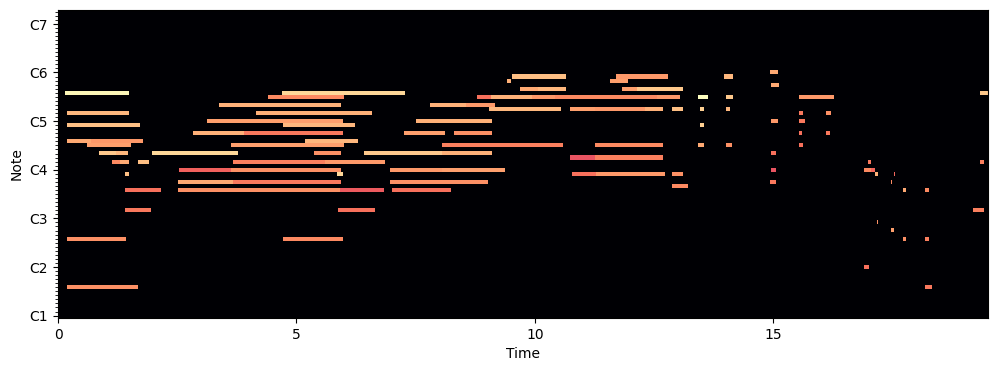

In [7]:
# Test: Print MIDI overview and piano roll for example MIDI

example1 = 'Debussy2_Alex_MIDI.mid'
example2 = 'Debussy2_Alex_U87_estMIDI.mid'

midi_overview(example1)
plt.figure(figsize=(12, 4))
plot_piano_roll(example1, 24, 100)

midi_overview(example2)
plt.figure(figsize=(12, 4))
plot_piano_roll(example2, 24, 100)

### 2.2 Comparing MIDI-to-MIDI similarity: Multi-f0 Evaluation with `mir_eval.multipitch`

`mir_eval.multipitch` class documentation can be found here: https://craffel.github.io/mir_eval/#module-mir_eval.multipitch

In [8]:
def get_midi_info(midi_name):

    '''
    For a given MIDI file name, get its MIDI note number, frequencies, and on/off times.

    Parameters
    ----------
    midi_name:  str
      Name of MIDI file, e.g. 'Bach_Alex_MIDI.mid'

    Returns
    -------
    midi_note:  1-d np.ndarray (int)
      MIDI number of notes

    note_freqs: 1-d np.ndarray (float)
      Frequencies in Hz, converted from MIDI number

    onset_time: 1-d np.ndarray (float)
      Onset time of notes, in seconds

    offset_time: 1-d np.ndarray (float)
      Offset time of notes, in seconds
    '''

    if search('estMIDI', midi_name):
        midi_path = data_home + est_midi_home + midi_name
    else:
        midi_path = data_home + ref_midi_home + midi_name

    pm = pretty_midi.PrettyMIDI(midi_path)

    midi_note = np.array([])
    note_freq = np.array([])
    onset_time = np.array([])
    offset_time = np.array([])

    for instrument in pm.instruments: # only 1 instrument here, but works for multi-instrument as well
        for note in instrument.notes:
            midi_note = np.append(midi_note, note.pitch)
            note_freq = np.append(note_freq, pretty_midi.note_number_to_hz(note.pitch))
            onset_time = np.append(onset_time, note.start)
            offset_time = np.append(offset_time, note.end)


    return midi_note, note_freq, onset_time, offset_time


In [9]:
# Test: Same length means the note data and events match

midi_note, note_freq, onset_time, offset_time = get_midi_info('Debussy2_Alex_MIDI.mid')
print(len(midi_note), len(note_freq), len(onset_time), len(offset_time))
#print(note_freq)


170 170 170 170


In [10]:
def parse_midi(ref_midi_name, est_midi_name, fps=10):

    '''
    Parse reference (ground truth) and estimation MIDI files into formats compatible with `mir_eval.multipitch`.
    Slice both MIDI files into equally-spaced time frames and document the frequencies in each frame.


    Parameters
    ----------
    ref_midi_name, est_midi_name: str
      Name of reference/estimation MIDI files

    fps: int
      Time frame resolution, in frames per second

    Returns
    -------
    ref_time, est_time: 1-d np.ndarray (float)
        Start times of each frame. For convenience, ref_time and est_time are identical to avoid resampling with
          `mir_eval.multipitch.resample_multipitch()`.

    ref_freqs, est_freqs: list of np.ndarray (float)
        Component frequencies for each time frame as an np.ndarray, sorted from lowest to highest.


    '''

    # Create PrettyMIDI objects
    ref_pm = pretty_midi.PrettyMIDI(data_home + ref_midi_home + ref_midi_name)
    est_pm = pretty_midi.PrettyMIDI(data_home + est_midi_home + est_midi_name)

    # Check fps compatibility with files
    # Too large fps may over-penalize

    dt = np.abs(ref_pm.get_end_time() - est_pm.get_end_time())
    if dt >= 5/fps:
        raise ValueError('Frame rate too large for file comparison. Suggested maximum fps={}.'.format(3//dt))


    # Base the timeline on the shorter file because:
    # (1) the excessive tail in the longer file is usually silence
    # (2) if extra notes do appear in the tail, either discard or count them to the last frame - the error is small

    timeline = np.min([ref_pm.get_end_time(), est_pm.get_end_time()])
    ref_time = np.arange(timeline * fps) / fps
    est_time = ref_time
    n_frames = len(ref_time)

    ref_freqs = [np.array([])] * n_frames
    est_freqs = [np.array([])] * n_frames # placeholders

    # Read MIDI data
    _, ref_note_freq, ref_onset_time, ref_offset_time = get_midi_info(ref_midi_name)
    _, est_note_freq, est_onset_time, est_offset_time = get_midi_info(est_midi_name)

    # Parse reference MIDI, very stupid way
    for i in range(len(ref_note_freq)):
        # Calculate the frames it belongs to
        frame_index = np.arange(ref_onset_time[i]*fps, ref_offset_time[i]*fps+1, dtype=int)

        for j in frame_index:
            # make sure frame index is smaller than largest possible
            if j >= n_frames-1:
                break
            else:
                # append freq value to freq array of thi time frame
                ref_freqs[j] = np.append(ref_freqs[j], ref_note_freq[i])

    # Parse estimation MIDI, the same stupid hard-code way
    for i in range(len(est_note_freq)):
        # Calculate the frames it belongs to
        frame_index = np.arange(est_onset_time[i]*fps, est_offset_time[i]*fps+1, dtype=int)

        for j in frame_index:
            # make sure frame index is smaller than largest possible
            if j >= n_frames-1:
                break
            else:
                # append freq value to freq array of thi time frame
                est_freqs[j] = np.append(est_freqs[j], est_note_freq[i])

    # Sort the freqs in each array in ascending order, with np.sort() default
    for k in range(n_frames):
        ref_freqs[k] = np.sort(ref_freqs[k])
        est_freqs[k] = np.sort(est_freqs[k])



    return ref_time, ref_freqs, est_time, est_freqs

In [ ]:
# Test: Too large fps input and error-raising
# Error-raising is working! Un-comment to test run
# ref_time, ref_freqs, est_time, est_freqs = parse_midi('Debussy2_Alex_MIDI.mid', 'Debussy2_Alex_U87_estMIDI.mid', fps=200)

In [11]:
# Test: Try a sample refMIDI - estMIDI pair

ref_time, ref_freqs, est_time, est_freqs = parse_midi('Debussy2_Alex_MIDI.mid', 'Debussy2_Alex_U87_estMIDI.mid', fps=20)

# Validate the inputs match
mir_eval.multipitch.validate(ref_time, ref_freqs, est_time, est_freqs)

# Generate evaluation dictionary with metric scores, default error range is 1 semitone
eva = mir_eval.multipitch.evaluate(ref_time, ref_freqs, est_time, est_freqs)
for key in eva.keys():
    print('{}:{}'.format(key, eva[key]))

Precision:0.3285931945149822
Recall:0.7549591598599766
Accuracy:0.296925195043598
Substitution Error:0.12485414235705951
Miss Error:0.12018669778296383
False Alarm Error:1.4177362893815635
Total Error:1.662777129521587
Chroma Precision:0.36312849162011174
Chroma Recall:0.8343057176196033
Chroma Accuracy:0.3387020369493131
Chroma Substitution Error:0.045507584597432905
Chroma Miss Error:0.12018669778296383
Chroma False Alarm Error:1.4177362893815635
Chroma Total Error:1.5834305717619603



## 3. Import Audio and MIDI data and store as Python dictionary

The pair-wise (estimation MIDI, reference MIDI) file names are stored as 2 columns in a .txt file

In [12]:
# load .txt file with MIDI file names as a (n,2) list
# n: number of test audio clips
# first column is the predicted MIDI from piano-scribe, second column is the ground truth MIDI

filename_path = data_home + 'load.txt'

filename_list = np.loadtxt(filename_path, dtype=str)

print(filename_list.shape)

(42, 2)


In [13]:
# Call on a specific file name

print(filename_list[0][1])

Bach_Alex_MIDI.mid


In [ ]:
# Making dictionary

dataset = {}

# Reads txt until the last row
for track_id in range(filename_list.shape[0]):

  dataset[track_id]= {}

  # [track_id][1] ground truth mid.
  dataset[track_id]['recording']= filename_list[track_id][1]

  # [track_id][0] piano-scribe mid.
  dataset[track_id]['estimate'] = filename_list[track_id][0]



In [ ]:
# Test dictionary data

print(dataset[3]['recording'])

Bach_Alex_MIDI.mid


## 4. Data Analysis

In [ ]:
# Calculate metric scores for all refMIDI - estMIDI pairs

for track_id in dataset.keys():

    #print(dataset[track_id])


    ref_midi = dataset[track_id]['recording']
    est_midi = dataset[track_id]['estimate']

    #Getting midi info, and parsing to match mir_eval input
    ref_time, ref_freqs, est_time, est_freqs = parse_midi(ref_midi, est_midi, fps=2)


    # Validate the inputs match
    mir_eval.multipitch.validate(ref_time, ref_freqs, est_time, est_freqs)

    # Generate evaluation dictionary with metric scores, default error range is 1 semitone
    eva = mir_eval.multipitch.evaluate(ref_time, ref_freqs, est_time, est_freqs)
    #for key in eva.keys():
    #  print('{}:{}'.format(key, eva[key]))

    #Putting results in dictionary
    for key in eva.keys():
      dataset[track_id][str(key)] = eva[key]


### 4.1 Quantitative Analysis

In [ ]:
dataset[0]

{'recording': 'Bach_Alex_MIDI.mid',
 'estimate': 'Bach_Alex_MKH8040_estMIDI.mid',
 'Precision': 0.6476608187134503,
 'Recall': 0.977924944812362,
 'Accuracy': 0.638328530259366,
 'Substitution Error': 0.019867549668874173,
 'Miss Error': 0.002207505518763797,
 'False Alarm Error': 0.5121412803532008,
 'Total Error': 0.5342163355408388,
 'Chroma Precision': 0.6535087719298246,
 'Chroma Recall': 0.9867549668874173,
 'Chroma Accuracy': 0.6478260869565218,
 'Chroma Substitution Error': 0.011037527593818985,
 'Chroma Miss Error': 0.002207505518763797,
 'Chroma False Alarm Error': 0.5121412803532008,
 'Chroma Total Error': 0.5253863134657837}

In [ ]:
Precision = []
Recall = []
Accuracy = []
Substitution_Error = []
Miss_Error = []
False_Alarm_Error = []
Total_Error = []
Chroma_Precision= []
Chroma_Recall= []
Chroma_Accuracy= []
Chroma_Substitution_Error= []
Chroma_Miss_Error = []
Chroma_False_Alarm_Error= []
Chroma_Total_Error= []

for track_id in dataset.keys():
  #print(track_id)

    Precision = np.append(Precision, dataset[track_id]['Precision'])
    Recall = np.append(Precision, dataset[track_id]['Recall'])
    Accuracy = np.append(Precision, dataset[track_id]['Accuracy'])
    Substitution_Error = np.append(Precision, dataset[track_id]['Substitution Error'])
    Miss_Error = np.append(Precision, dataset[track_id]['Miss Error'])
    False_Alarm_Error = np.append(Precision, dataset[track_id]['False Alarm Error'])
    Total_Error = np.append(Precision, dataset[track_id]['Total Error'])
    Chroma_Precision= np.append(Precision, dataset[track_id]['Chroma Precision'])
    Chroma_Recall= np.append(Precision, dataset[track_id]['Chroma Recall'])
    Chroma_Accuracy= np.append(Precision, dataset[track_id]['Chroma Accuracy'])
    Chroma_Substitution_Error= np.append(Precision, dataset[track_id]['Chroma Substitution Error'])
    Chroma_Miss_Error = np.append(Precision, dataset[track_id]['Chroma Miss Error'])
    Chroma_False_Alarm_Error= np.append(Precision, dataset[track_id]['Chroma False Alarm Error'])
    Chroma_Total_Error= np.append(Precision, dataset[track_id]['Chroma Total Error'])



In [ ]:
labels = []

for key in dataset[0].keys():
  #print(key)
  if key == 'recording':
    pass
  elif key == 'estimate':
    pass
  else:
    #print(key)
    labels = np.append(labels, str(key))

In [ ]:
labels

array(['Precision', 'Recall', 'Accuracy', 'Substitution Error',
       'Miss Error', 'False Alarm Error', 'Total Error',
       'Chroma Precision', 'Chroma Recall', 'Chroma Accuracy',
       'Chroma Substitution Error', 'Chroma Miss Error',
       'Chroma False Alarm Error', 'Chroma Total Error'], dtype='<U32')

In [ ]:
results = [Precision,
    Recall,
    Accuracy,
    Substitution_Error,
    Miss_Error,
    False_Alarm_Error,
    Total_Error,
    Chroma_Precision,
    Chroma_Recall,
    Chroma_Accuracy,
    Chroma_Substitution_Error,
    Chroma_Miss_Error,
    Chroma_False_Alarm_Error,
    Chroma_Total_Error ]

In [ ]:
#Mean for each
for i in range (len(results)):
  print(labels[i],': ',np.mean(results[i]))

Precision :  0.6435145137771501
Recall :  0.6506490183575788
Accuracy :  0.6415505559564112
Substitution Error :  0.6297049155326678
Miss Error :  0.6285490599683791
False Alarm Error :  0.6436676507492751
Total Error :  0.6448235063135638
Chroma Precision :  0.642278395916824
Chroma Recall :  0.6512038290284373
Chroma Accuracy :  0.6420666742473937
Chroma Substitution Error :  0.6291501048618092
Chroma Miss Error :  0.6285490599683791
Chroma False Alarm Error :  0.6436676507492751
Chroma Total Error :  0.6442686956427053


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


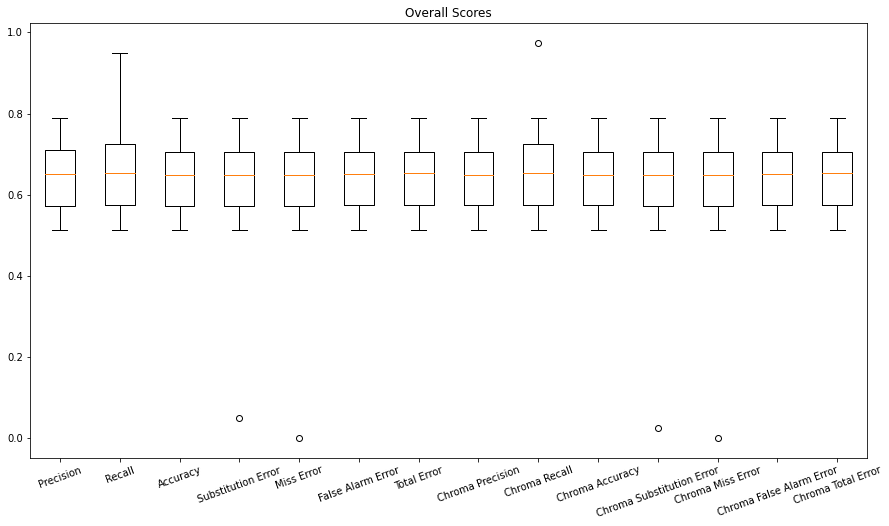

In [ ]:
data = [
    Precision,
    Recall,
    Accuracy,
    Substitution_Error,
    Miss_Error,
    False_Alarm_Error,
    Total_Error,
    Chroma_Precision,
    Chroma_Recall,
    Chroma_Accuracy,
    Chroma_Substitution_Error,
    Chroma_Miss_Error,
    Chroma_False_Alarm_Error,
    Chroma_Total_Error ]

fig, ax = plt.subplots()

fig.set_figwidth(15)
fig.set_figheight(8)

plt.title('Overall Scores')
plt.xticks(rotation = 20)
ax.set_xticklabels(labels)
ax.boxplot(data)


plt.show();

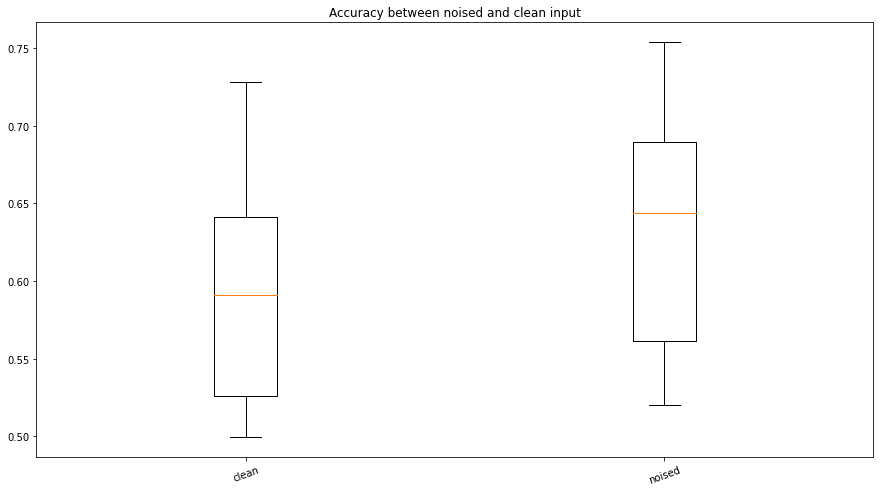

In [ ]:
# Compare Audio_clean vs Audio _noise

clean = []
noised= []

metric = 'Accuracy'

for track_id in dataset.keys():
  track = dataset[track_id]['estimate']
  #print(track)

  if track.find('_Noised') != -1:  #if '_Noised' in track name
    noised = np.append(noised, dataset[track_id][metric])
  else:
    clean  = np.append(clean, dataset[track_id][metric])


data = [clean, noised]
labels = ['clean', 'noised']

fig, ax = plt.subplots()

fig.set_figwidth(15)
fig.set_figheight(8)

plt.title('Accuracy between noised and clean input')
plt.xticks(rotation = 20)
ax.set_xticklabels(labels)
ax.boxplot(data)


plt.show();

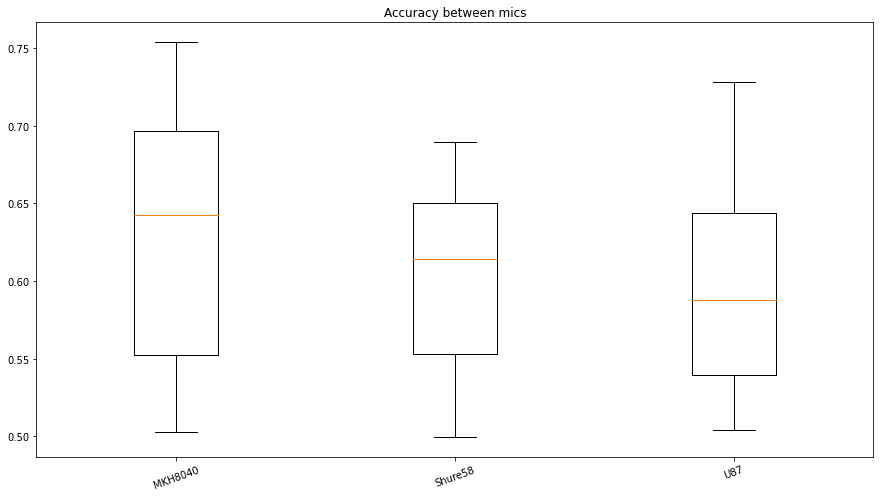

In [ ]:
# Compare Mic

MKH8040 = []
Shure58 = []
U87 = []


metric = 'Accuracy'

for track_id in dataset.keys():
  track = dataset[track_id]['estimate']
  #print(track)

  if track.find('MKH8040') != -1:  #if 'MKH8040' in track name
    MKH8040 = np.append(MKH8040, dataset[track_id][metric])
  elif track.find('Shure58') != -1:
    Shure58  = np.append(Shure58, dataset[track_id][metric])
  elif track.find('U87') != -1:
    U87 = np.append(U87, dataset[track_id][metric])


data = [MKH8040, Shure58, U87]
labels = ['MKH8040', 'Shure58', 'U87']

fig, ax = plt.subplots()

fig.set_figwidth(15)
fig.set_figheight(8)

plt.title('Accuracy between mics')
plt.xticks(rotation = 20)
ax.set_xticklabels(labels)
ax.boxplot(data)


plt.show();

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


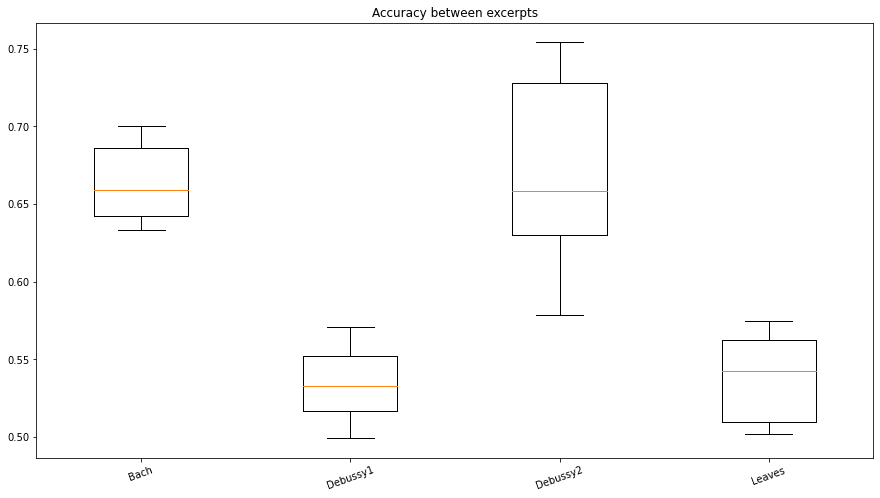

In [ ]:
# Compare which piece/excerpt
Bach = []
Debussy1 = []
Debussy2 = []
Leaves = []

metric = 'Accuracy'

for track_id in dataset.keys():
  track = dataset[track_id]['estimate']
  #print(track)

  if track.find('Bach') != -1:
    Bach = np.append(Bach, dataset[track_id][metric])
  elif track.find('Debussy1') != -1:
    Debussy1  = np.append(Debussy1, dataset[track_id][metric])
  elif track.find('Debussy2') != -1:
    Debussy2 = np.append(Debussy2, dataset[track_id][metric])
  elif track.find('Leaves') != -1:
    Leaves = np.append(Leaves, dataset[track_id][metric])


data = [Bach, Debussy1, Debussy2, Leaves]
labels = ['Bach', 'Debussy1', 'Debussy2', 'Leaves']

fig, ax = plt.subplots()

fig.set_figwidth(15)
fig.set_figheight(8)

plt.title('Accuracy between excerpts')
plt.xticks(rotation = 20)
ax.set_xticklabels(labels)
ax.boxplot(data)


plt.show();

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


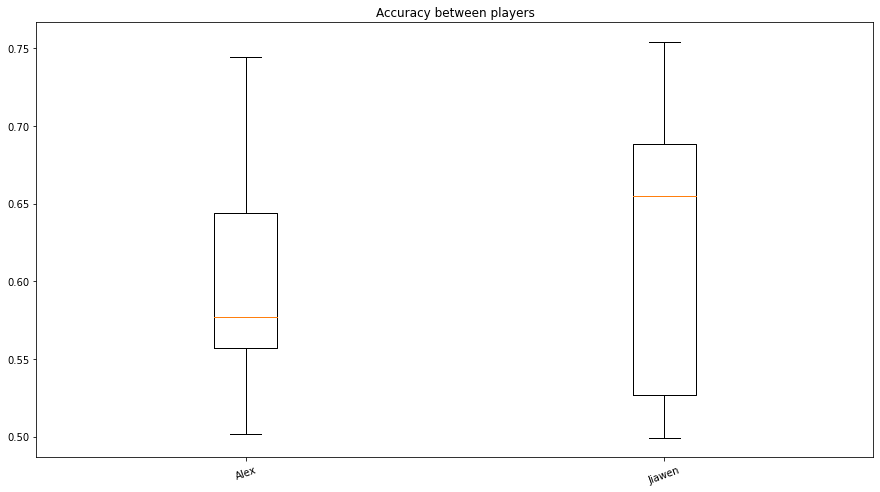

In [ ]:
# Compare player

Alex = []
Jiawen= []

metric = 'Accuracy'

for track_id in dataset.keys():
  track = dataset[track_id]['estimate']
  #print(track)

  if track.find('Alex') != -1:
    Alex = np.append(Alex, dataset[track_id][metric])
  else:
    Jiawen = np.append(Jiawen, dataset[track_id][metric])


data = [Alex, Jiawen]
labels = ['Alex', 'Jiawen']

fig, ax = plt.subplots()

fig.set_figwidth(15)
fig.set_figheight(8)

plt.title('Accuracy between players')
plt.xticks(rotation = 20)
ax.set_xticklabels(labels)
ax.boxplot(data)


plt.show();

### 4.2 Qualitative Analysis

In [ ]:
from IPython.display import Audio

### 4.2.1 Estimation with highest Precision score

In [ ]:
# Find highest Precision

index = np.argmax(Precision)
est_midi_name = dataset[index]['estimate']
print(est_midi_name)
print('Highest precision: {:.4f}'.format(np.amax(Precision)))

# Find reference MIDI name corresponding to estimation MIDI
for track_id in range(filename_list.shape[0]):
   if dataset[track_id]['estimate'] == est_midi_name:
      ref_midi_name = dataset[track_id]['recording']
      break

Debussy2_Alex_MKH8040_Noised_estMIDI.mid
Highest precision: 0.7893


In [ ]:
# Recording of original clip
audio_path = dataset[index]['estimate'].replace('_estMIDI.mid', '.wav')
audio_path = data_home + 'Audio/' + audio_path
y ,sr  = librosa.load(audio_path)

Audio (y ,rate = sr)

In [ ]:
# Estimated MIDI synthesized audio
est_midi_path = data_home + est_midi_home + est_midi_name
print(est_midi_path)

pm = pretty_midi.PrettyMIDI(est_midi_path)
y = pm.synthesize(fs = sr)
Audio(y ,rate = sr)

/content/drive/MyDrive/MIRFP/MIDI_estMIDI/Debussy2_Alex_MKH8040_Noised_estMIDI.mid


/usr/local/lib/python3.8/dist-packages/librosa/display.py:1335: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  warnings.warn(


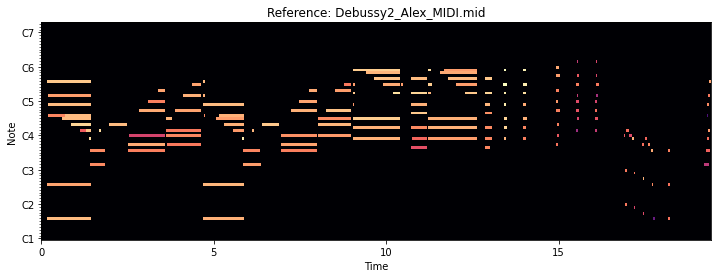

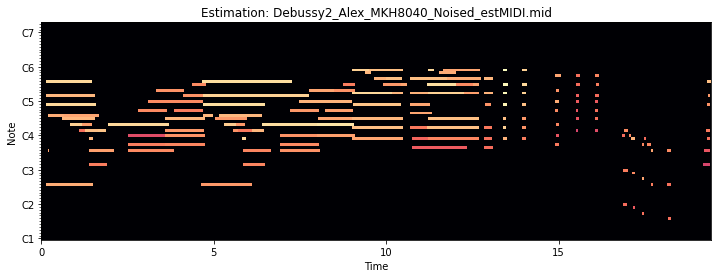

In [ ]:
# Plot piano rolls

plt.figure(figsize=(12, 4))
plt.title('Reference: {}'.format(ref_midi_name))
plot_piano_roll(ref_midi_name, 24, 100)

plt.figure(figsize=(12, 4))
plt.title('Estimation: {}'.format(est_midi_name))
plot_piano_roll(est_midi_name, 24, 100)

### 4.2.2 Estimation with lowest Precision score

In [ ]:
# Find lowest Precision

index = np.argmin(Precision)
est_midi_name = dataset[index]['estimate']
print(est_midi_name)
print('Lowest precision: {:.4f}'.format(np.amin(Precision)))

# Find reference MIDI name corresponding to estimation MIDI
for track_id in range(filename_list.shape[0]):
   if dataset[track_id]['estimate'] == est_midi_name:
      ref_midi_name = dataset[track_id]['recording']
      break

Leaves_Alex_Shure58_estMIDI.mid
Lowest precision: 0.5122


In [ ]:
# Recording
audio_path = dataset[index]['estimate'].replace('_estMIDI.mid', '.wav')
audio_path = data_home + 'Audio/' + audio_path
y ,sr  = librosa.load(audio_path)

Audio (y ,rate = sr)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# estimated MIDI synthesized audio
midi_name = dataset[index]['estimate']
midi_path = data_home + est_midi_home + midi_name
print(midi_path)

pm = pretty_midi.PrettyMIDI(data_home + est_midi_home + midi_name)
y = pm.synthesize(fs = sr)
Audio(y ,rate = sr)


Output hidden; open in https://colab.research.google.com to view.

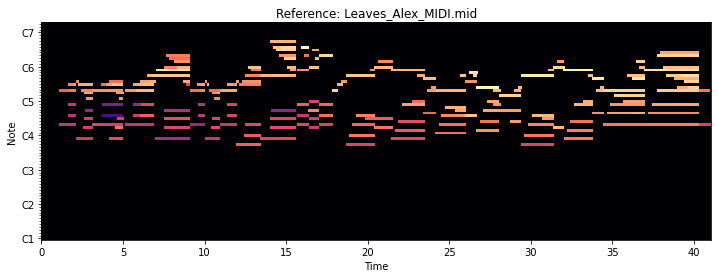

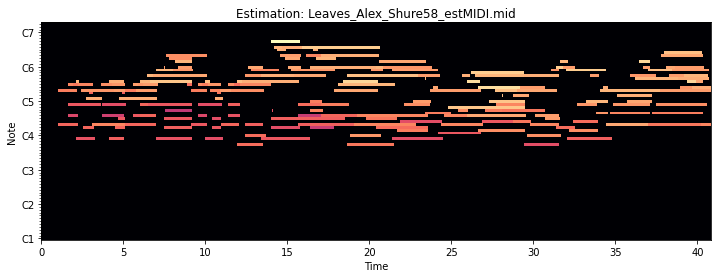

In [ ]:
# Plot piano rolls

plt.figure(figsize=(12, 4))
plt.title('Reference: {}'.format(ref_midi_name))
plot_piano_roll(ref_midi_name, 24, 100)

plt.figure(figsize=(12, 4))
plt.title('Estimation: {}'.format(est_midi_name))
plot_piano_roll(est_midi_name, 24, 100)

### 4.2.3 Estimation with highest Accuracy score

In [ ]:
# Find highest Accuracy

index = np.argmax(Accuracy)
est_midi_name = dataset[index]['estimate']
print(est_midi_name)
print('Highest accuracy: {:.4f}'.format(np.amax(Accuracy)))

# Find reference MIDI name corresponding to estimation MIDI
for track_id in range(filename_list.shape[0]):
   if dataset[track_id]['estimate'] == est_midi_name:
      ref_midi_name = dataset[track_id]['recording']
      break

Debussy2_Alex_MKH8040_Noised_estMIDI.mid
Highest accuracy: 0.7893


In [ ]:
# Recording
audio_path = dataset[index]['estimate'].replace('_estMIDI.mid', '.wav')
audio_path = data_home + 'Audio/' + audio_path
y ,sr  = librosa.load(audio_path)

Audio (y ,rate = sr)

In [ ]:
# estimated MIDI synthesized audio
midi_name = dataset[index]['estimate']
midi_path = data_home + est_midi_home + midi_name
print(midi_path)

pm = pretty_midi.PrettyMIDI(data_home + est_midi_home + midi_name)
y = pm.synthesize(fs = sr)
Audio(y ,rate = sr)


/content/drive/MyDrive/MIRFP/MIDI_estMIDI/Debussy2_Alex_MKH8040_Noised_estMIDI.mid


/usr/local/lib/python3.8/dist-packages/librosa/display.py:1335: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  warnings.warn(


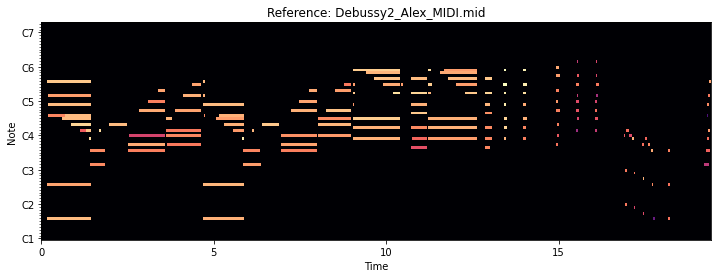

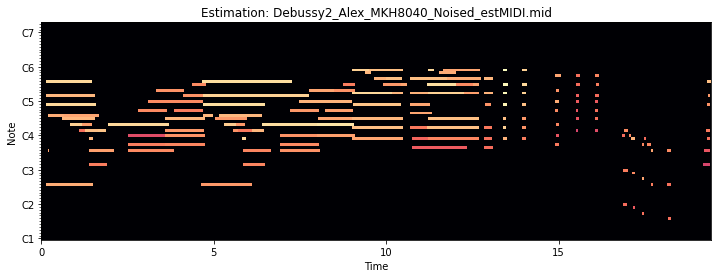

In [ ]:
# Plot piano rolls

plt.figure(figsize=(12, 4))
plt.title('Reference: {}'.format(ref_midi_name))
plot_piano_roll(ref_midi_name, 24, 100)

plt.figure(figsize=(12, 4))
plt.title('Estimation: {}'.format(est_midi_name))
plot_piano_roll(est_midi_name, 24, 100)

### 4.2.4 Estimation with lowest Accuracy score

In [ ]:
# Find lowest Accuracy

index = np.argmin(Accuracy)
est_midi_name = dataset[index]['estimate']
print(est_midi_name)
print('Lowest accuracy: {:.4f}'.format(np.amin(Accuracy)))

# Find reference MIDI name corresponding to estimation MIDI
for track_id in range(filename_list.shape[0]):
   if dataset[track_id]['estimate'] == est_midi_name:
      ref_midi_name = dataset[track_id]['recording']
      break

Leaves_Alex_Shure58_estMIDI.mid
Lowest accuracy: 0.5122


In [ ]:
# Recording
audio_path = dataset[index]['estimate'].replace('_estMIDI.mid', '.wav')
audio_path = data_home + 'Audio/' + audio_path
y ,sr  = librosa.load(audio_path)

Audio (y ,rate = sr)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# estimated MIDI synthesized audio
midi_name = dataset[index]['estimate']
midi_path = data_home + est_midi_home + midi_name
print(midi_path)

pm = pretty_midi.PrettyMIDI(data_home + est_midi_home + midi_name)
y = pm.synthesize(fs = sr)
Audio(y ,rate = sr)

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.8/dist-packages/librosa/display.py:1335: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  warnings.warn(


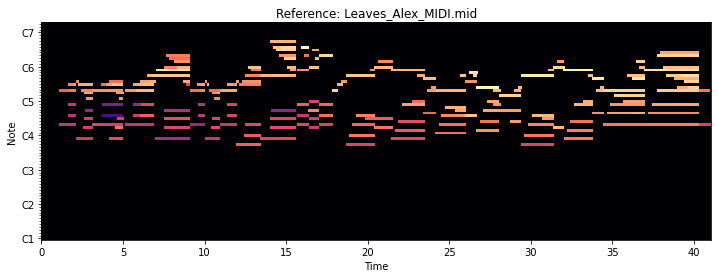

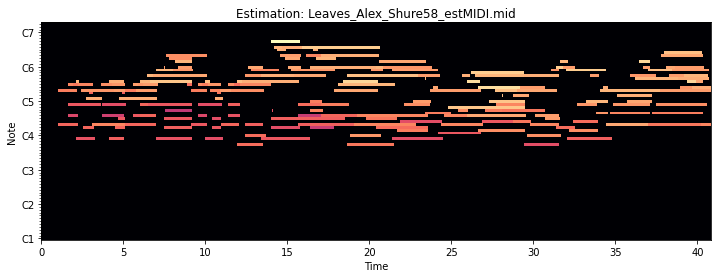

In [ ]:
# Plot piano rolls

plt.figure(figsize=(12, 4))
plt.title('Reference: {}'.format(ref_midi_name))
plot_piano_roll(ref_midi_name, 24, 100)

plt.figure(figsize=(12, 4))
plt.title('Estimation: {}'.format(est_midi_name))
plot_piano_roll(est_midi_name, 24, 100)